In [1]:
import rasterio
from pathlib import Path 
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Data Check
## treepoint data list
- manup_treepoint.shp
- mandown_treepoint.shp
- br_rest1_treepoint.shp
- br_rest2_treepoint.shp

In [2]:
# 1. family change function
def sc_change(tp):
    tp_sc = tp['family']
    # family string to int
    tp_sc = tp_sc.to_frame()
    sc_list = {'family':{'Fabaceae / Leguminosae - Pea family':'1', 'Platanaceae - Plane-tree family':'2', 'Aceraceae - Maple family':'3',
                         'Fagaceae - Beech family':'4', 'Rosaceae - Rose family':'5', 'Conifer':'6', 'broad-leaf tree':'7'}}
    tp_sc = tp_sc.replace(sc_list)
    
    # change
    tp.drop(["GenusSpeci", "OBJECTID", "Lat", "Long", 'family'], axis = 1, inplace=True)
    tp = pd.concat([tp, tp_sc], axis=1)
    
    return tp

In [3]:
## result: ['geo','family'(number)] || up(28273,2) down(24128,2) br(33398,2)

# 1. Point Sampling
- NDVI point smapling and Delete under 0.2
- Point Sampling

In [4]:
# 2. Set the feature & area
feature = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
           "MEAN", "VAR", "HOMO", "CONT", "DISSI", "ENTROPY", "SECOND", "CORR"]
area = ['manup', 'mandown', 'br']
# ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI'], 'outglcm_mandown'
# ['NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']'br', 'brleft', 'manup', 'brup', 'manmid' 'mandown'
# "mean", "variance", "homogeneity", "contrast",  "dissimilarity", "entropy", "second_moment", "correlation"
for i in feature:
    for j in area:
        globals()[f'{i}{j}_file'] = '../KOMPSAT 위성영상/데이터 전처리/4. data/'+j+'/'+i+'.tif'
        globals()[f'{i}{j}_src'] = rasterio.open(globals()[f'{i}{j}_file'])

In [5]:
## result: ['geo','family', 'NDVI'] || up(16979,3) down(15042,3) br(24028,3)

In [6]:
# 3. Point Sampling - Store 3by3 geometry
def PSgeo(tp):
    # 가져올 픽셀의 좌표값 설정 (3by3)
    WIDTH = 0.00000599299783809013749338974087784241
    HEIGHT = 0.0000059299783809007439469768700121737
    coord_list0= [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list1= [(x-WIDTH, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list2= [(x, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list3= [(x+WIDTH,y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list4= [(x+WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list5= [(x+WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list6= [(x,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list7= [(x-WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list8= [(x-WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list = [coord_list0, coord_list1, coord_list2, coord_list3, coord_list4, coord_list5, coord_list6, coord_list7, coord_list8]
    return coord_list

In [7]:
# 3. Point Sampling
def PointSampling(file, src, coord_list):   
    ttp = pd.DataFrame()

    # 3by3에 대한 geometry를 dataframe에 column으로 추가
    ttp['geometry'] = coord_list[0] + coord_list[1] + coord_list[2] + coord_list[3] + coord_list[4] + coord_list[5] + coord_list[6] + coord_list[7] + coord_list[8]

    # 해당 dataframe으로 포인트 샘플링 실행
    ttp[Path(file).stem] = [x for x in src.sample(ttp['geometry'])] # 포인트 샘플링
    ttp[Path(file).stem] = ttp[Path(file).stem].astype('float64') # NDVI 값을 float으로 바꿈
    
    ttp.drop(['geometry'], axis=1, inplace=True)
    
    return ttp

In [8]:
def onlyPointSampling(file, src, tp):
    ttp = pd.DataFrame()
    ttp['geometry'] = [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    # 해당 dataframe으로 포인트 샘플링 실행
    ttp[Path(file).stem] = [x for x in src.sample(ttp['geometry'])] # 포인트 샘플링
    ttp[Path(file).stem] = ttp[Path(file).stem].astype('float64') # NDVI 값을 float으로 바꿈
    ttp.drop(['geometry'], axis=1, inplace=True)

    return ttp

In [9]:
# 3. Point Sampling - merge

In [10]:
## 3by3 PS 한번에 돌리려고 했는데 모르겠음
# for i in ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI']:
#     for j in [up, down, br]:
#         PointSampling(globals()[f'{i}{j}_file'], globals()[f'{i}{j}_src'], globals()[f'{j}'])

# 2. Data pretreatment

In [11]:
# 4. delete the 3by3 kernel NDVI values under 0.2 
def NDVIkn02(tp):
    tp.drop(tp[tp['NDVI']<0.2].index, inplace=True)
    tp.reset_index(drop=True, inplace=True)
    return tp

# 3. Run

In [12]:
# data load
tp_up = gpd.GeoDataFrame.from_file("newtree_point/manuup.shp")
# tp_mid = gpd.GeoDataFrame.from_file("newtree_point/manmid.shp")
tp_down = gpd.GeoDataFrame.from_file("newtree_point/mandown.shp")
tp_br1 = gpd.GeoDataFrame.from_file("newtree_point/br_rest1.shp")
tp_br2 = gpd.GeoDataFrame.from_file("newtree_point/br_rest2.shp")
# tp_brup = gpd.GeoDataFrame.from_file("newtree_point/brup.shp")
# tp_brleft = gpd.GeoDataFrame.from_file("newtree_point/brleft.shp")
tp_br = gpd.GeoDataFrame( pd.concat( [tp_br1, tp_br2], ignore_index=True) )

tp_brtest = gpd.GeoDataFrame.from_file("newtree_point/br_test.shp")
tp_brtest_peak = gpd.GeoDataFrame.from_file("br_test_peak/br_test_peak_last.shp")

In [13]:
tp_brtest_peak

,Long,Lat,geometry
0,-73.955971,40.670262,POINT (-73.95597 40.67026)
1,-73.962150,40.671430,POINT (-73.96215 40.67143)
2,-73.962322,40.671424,POINT (-73.96232 40.67142)
3,-73.961937,40.671306,POINT (-73.96194 40.67131)
4,-73.962286,40.671246,POINT (-73.96229 40.67125)
...,...,...,...
24205,-73.943760,40.631108,POINT (-73.94376 40.63111)
24206,-73.944471,40.631096,POINT (-73.94447 40.63110)
24207,-73.943446,40.631084,POINT (-73.94345 40.63108)
24208,-73.943849,40.631048,POINT (-73.94385 40.63105)


In [14]:
# 1. run family change
manup = sc_change(tp_up)
mandown = sc_change(tp_down)
br = sc_change(tp_br)
# brleft = sc_change(tp_brleft)
brtest = sc_change(tp_brtest)

In [15]:
brtest

,geometry,family
0,POINT (-73.95343 40.64235),2
1,POINT (-73.94945 40.66159),3
2,POINT (-73.94728 40.65575),6
3,POINT (-73.95075 40.66097),5
4,POINT (-73.95622 40.66053),2
...,...,...
15678,POINT (-73.93965 40.63963),1
15679,POINT (-73.96140 40.66186),6
15680,POINT (-73.93852 40.63814),7
15681,POINT (-73.93968 40.63987),5


In [16]:
brpeak = tp_brtest_peak.drop(["Lat", "Long"], axis = 1)

In [17]:
brpeak

,geometry
0,POINT (-73.95597 40.67026)
1,POINT (-73.96215 40.67143)
2,POINT (-73.96232 40.67142)
3,POINT (-73.96194 40.67131)
4,POINT (-73.96229 40.67125)
...,...
24205,POINT (-73.94376 40.63111)
24206,POINT (-73.94447 40.63110)
24207,POINT (-73.94345 40.63108)
24208,POINT (-73.94385 40.63105)


In [18]:
# 3-1. Create the coord_list
coord_manup = PSgeo(manup)
coord_mandown = PSgeo(mandown)
coord_br = PSgeo(br)

In [19]:
# Create manupLC
manupLC = manup.drop(['geometry'], axis=1)
manupLCM = pd.concat([manupLC, manupLC, manupLC, manupLC, manupLC, manupLC, manupLC, manupLC, manupLC], axis=0, ignore_index=True)
mandownLC = mandown.drop(['geometry'], axis=1)
mandownLCM = pd.concat([mandownLC, mandownLC, mandownLC, mandownLC, mandownLC, mandownLC, mandownLC, mandownLC, mandownLC], axis=0, ignore_index=True)
brLC = br.drop(['geometry'], axis=1)
brLCM = pd.concat([brLC, brLC, brLC, brLC, brLC, brLC, brLC, brLC, brLC], axis=0, ignore_index=True)

In [25]:
# 3-2. run 3by3 PointSampling
# 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI'
# 'NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI'
# manup
manupNDVI = PointSampling(NDVImanup_file, NDVImanup_src, coord_manup)
manupSBI = PointSampling(SBImanup_file, SBImanup_src, coord_manup)
manupGVI = PointSampling(GVImanup_file, GVImanup_src, coord_manup)
manupYVI = PointSampling(YVImanup_file, YVImanup_src, coord_manup)
manupWBI = PointSampling(WBImanup_file, WBImanup_src, coord_manup)
manupGCI = PointSampling(GCImanup_file, GCImanup_src, coord_manup)
manupAVI = PointSampling(AVImanup_file, AVImanup_src, coord_manup)
manupSIPI = PointSampling(SIPImanup_file, SIPImanup_src, coord_manup)
manupARVI = PointSampling(ARVImanup_file, ARVImanup_src,coord_manup)
manupEVI = PointSampling(EVImanup_file, EVImanup_src, coord_manup)
# GLCM
manupMEAN = PointSampling(MEANmanup_file, MEANmanup_src, coord_manup)
manupVAR = PointSampling(VARmanup_file, VARmanup_src, coord_manup)
manupHOMO = PointSampling(HOMOmanup_file, HOMOmanup_src, coord_manup)
manupCONT = PointSampling(CONTmanup_file, CONTmanup_src, coord_manup)
manupDISSI = PointSampling(DISSImanup_file, DISSImanup_src, coord_manup)
manupENTROPY = PointSampling(ENTROPYmanup_file, ENTROPYmanup_src, coord_manup)
manupSECOND = PointSampling(SECONDmanup_file, SECONDmanup_src, coord_manup)
manupCORR = PointSampling(CORRmanup_file, CORRmanup_src, coord_manup)

In [26]:
manupM = pd.concat([manupLCM, manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI,
                   manupMEAN, manupVAR, manupHOMO, manupCONT, manupDISSI, manupENTROPY, manupSECOND, manupCORR], axis=1, ignore_index=True)
manupM.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI',
                 "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]
# manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI

In [27]:
manupM

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,3,0.061114,0.374162,-0.013460,-0.048812,-0.040776,0.140391,0.001336,0.751088,0.039060,0.066906,0.297188,98.204056,0.546629,6.7568,1.5000,4.196662,0.022258,0.739544
1,7,-0.068959,0.255383,-0.051123,-0.012193,-0.020590,-0.237101,-0.000475,3.309723,0.040533,-0.058990,0.228687,58.323307,0.629680,6.3968,1.2952,3.745439,0.055894,0.656323
2,5,-0.001804,0.466557,-0.031791,-0.084174,-0.052798,0.042745,-0.000055,-26.215802,-0.026071,-0.002111,0.321088,114.975441,0.501310,9.2496,1.7080,4.388372,0.017042,0.634677
3,7,0.038803,0.333104,-0.004139,-0.057318,-0.049793,0.253405,0.000753,2.314599,-0.006391,0.033555,0.316994,107.470734,0.627238,2.4516,0.9900,3.993141,0.026533,0.879233
4,4,0.227972,0.381038,0.036536,-0.039276,-0.031267,0.466907,0.006526,0.748171,0.155994,0.276787,0.320456,109.985046,0.567291,3.6036,1.2484,4.206141,0.021649,0.840156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259231,2,0.553983,0.299401,0.121343,-0.019940,-0.008744,1.486580,0.016102,0.803144,0.426371,0.555950,0.380594,141.648117,0.689122,1.0956,0.6996,3.191424,0.057655,0.822416
259232,4,0.038600,0.295439,-0.018417,-0.033908,-0.033506,0.090459,0.000517,0.101440,0.036714,0.033711,0.251662,76.365158,0.593248,10.3496,1.5272,3.960484,0.038154,0.642357
259233,2,-0.033289,0.331781,-0.036643,-0.036950,-0.048608,0.027159,-0.000501,1.802940,-0.003184,-0.033549,0.236606,61.636971,0.652211,7.6620,1.1908,3.513306,0.046199,0.547557
259234,4,-0.046740,0.248119,-0.042756,-0.015990,-0.021820,-0.176319,-0.000334,3.689474,0.036349,-0.036773,0.260331,82.109756,0.538749,11.6732,1.8436,4.284716,0.027480,0.680551


In [28]:
# mandown
mandownNDVI = PointSampling(NDVImandown_file, NDVImandown_src, coord_mandown)
mandownSBI = PointSampling(SBImandown_file, SBImandown_src, coord_mandown)
mandownGVI = PointSampling(GVImandown_file, GVImandown_src, coord_mandown)
mandownYVI = PointSampling(YVImandown_file, YVImandown_src, coord_mandown)
mandownWBI = PointSampling(WBImandown_file, WBImandown_src, coord_mandown)
mandownGCI = PointSampling(GCImandown_file, GCImandown_src, coord_mandown)
mandownAVI = PointSampling(AVImandown_file, AVImandown_src, coord_mandown)
mandownSIPI = PointSampling(SIPImandown_file, SIPImandown_src, coord_mandown)
mandownARVI = PointSampling(ARVImandown_file, ARVImandown_src, coord_mandown)
mandownEVI = PointSampling(EVImandown_file, EVImandown_src, coord_mandown)
# GLCM
mandownMEAN = PointSampling(MEANmandown_file, MEANmandown_src, coord_mandown)
mandownVAR = PointSampling(VARmandown_file, VARmandown_src, coord_mandown)
mandownHOMO = PointSampling(HOMOmandown_file, HOMOmandown_src, coord_mandown)
mandownCONT = PointSampling(CONTmandown_file, CONTmandown_src, coord_mandown)
mandownDISSI = PointSampling(DISSImandown_file, DISSImandown_src, coord_mandown)
mandownENTROPY = PointSampling(ENTROPYmandown_file, ENTROPYmandown_src, coord_mandown)
mandownSECOND = PointSampling(SECONDmandown_file, SECONDmandown_src, coord_mandown)
mandownCORR = PointSampling(CORRmandown_file, CORRmandown_src, coord_mandown)

In [29]:
mandownM = pd.concat([mandownLCM, mandownNDVI, mandownSBI, mandownGVI, mandownYVI, mandownWBI, mandownGCI, mandownAVI, mandownSIPI, mandownARVI, mandownEVI, 
                     mandownMEAN, mandownVAR, mandownHOMO, mandownCONT, mandownDISSI, mandownENTROPY, mandownSECOND, mandownCORR], axis=1, ignore_index=True)
mandownM.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [30]:
mandownM

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,7,-0.026757,0.174653,-0.039376,0.012700,-0.012812,-0.262193,-0.000075,15.606768,0.150597,-0.016139,0.216019,51.003017,0.626516,3.0004,1.0612,3.836403,0.037690,0.787659
1,1,0.610439,0.309251,0.139424,-0.006017,-0.013966,1.920033,0.019824,0.743262,0.496133,0.723380,0.281525,84.615990,0.618235,3.6936,1.0760,3.722012,0.035948,0.758733
2,1,0.423846,0.322056,0.094219,-0.019388,-0.028486,1.264643,0.012199,0.766600,0.312088,0.470389,0.325406,105.972923,0.601301,2.9932,1.1004,3.557269,0.050271,0.585543
3,7,-0.053312,0.256314,-0.042071,-0.009754,-0.035058,-0.084317,-0.000417,3.617103,0.039315,-0.046997,0.194394,44.897263,0.626607,6.4836,1.2356,3.663600,0.056349,0.623774
4,7,0.098032,0.284527,-0.012325,-0.016452,-0.029823,0.156297,0.001225,-0.188884,0.106306,0.095154,0.236231,64.016495,0.555860,4.8316,1.3876,4.223793,0.022180,0.782506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219361,7,0.275897,0.174060,-0.001763,0.015586,-0.010575,0.256354,0.001264,-0.373168,0.311347,0.177849,0.226581,64.496719,0.776804,1.2324,0.5660,2.964603,0.133212,0.956722
219362,2,-0.168874,0.168677,-0.047954,-0.002494,-0.013329,-0.394092,-0.000404,2.354601,0.024976,-0.082474,0.224538,56.024166,0.573952,5.2240,1.3744,3.851416,0.041018,0.672198
219363,1,-0.074563,0.162267,-0.038373,0.007941,-0.015595,-0.267494,-0.000182,5.389525,0.105224,-0.038327,0.211669,56.514500,0.615804,7.0572,1.4396,3.763976,0.061370,0.743648
219364,4,-0.018910,0.284995,-0.034468,-0.026869,-0.033430,-0.034937,-0.000206,4.352172,0.021361,-0.016628,0.249319,65.538574,0.633743,4.5740,1.1260,3.554690,0.054054,0.637143


In [20]:
# br
brNDVI = PointSampling(NDVIbr_file, NDVIbr_src, coord_br)
brSBI = PointSampling(SBIbr_file, SBIbr_src, coord_br)
brGVI = PointSampling(GVIbr_file, GVIbr_src, coord_br)
brYVI = PointSampling(YVIbr_file, YVIbr_src, coord_br)
brWBI = PointSampling(WBIbr_file, WBIbr_src, coord_br)
brGCI = PointSampling(GCIbr_file, GCIbr_src, coord_br)
brAVI = PointSampling(AVIbr_file, AVIbr_src, coord_br)
brSIPI = PointSampling(SIPIbr_file, SIPIbr_src, coord_br)
brARVI = PointSampling(ARVIbr_file, ARVIbr_src, coord_br)
brEVI = PointSampling(EVIbr_file, EVIbr_src, coord_br)
# GLCM
brMEAN = PointSampling(MEANbr_file, MEANbr_src, coord_br)
brVAR = PointSampling(VARbr_file, VARbr_src, coord_br)
brHOMO = PointSampling(HOMObr_file, HOMObr_src, coord_br)
brCONT = PointSampling(CONTbr_file, CONTbr_src, coord_br)
brDISSI = PointSampling(DISSIbr_file, DISSIbr_src, coord_br)
brENTROPY = PointSampling(ENTROPYbr_file, ENTROPYbr_src, coord_br)
brSECOND = PointSampling(SECONDbr_file, SECONDbr_src, coord_br)
brCORR = PointSampling(CORRbr_file, CORRbr_src, coord_br)

In [21]:
brM = pd.concat([brLCM, brNDVI, brSBI, brGVI, brYVI, brWBI, brGCI, brAVI, brSIPI, brARVI, brEVI, 
                     brMEAN, brVAR, brHOMO, brCONT, brDISSI, brENTROPY, brSECOND, brCORR], axis=1, ignore_index=True)
brM.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [22]:
brM

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.535585,0.301191,0.113777,-0.015810,-0.012022,0.0,0.0,0.0,0.0,0.0,147.325897,147.325897,0.722995,0.9656,0.6200,2.515520,0.133284,0.578643
1,7,0.553993,0.312186,0.121213,-0.011828,-0.012814,0.0,0.0,0.0,0.0,0.0,105.961746,105.961746,0.602862,2.0712,0.9904,3.930302,0.026422,0.880673
2,2,0.485875,0.318301,0.104866,-0.018346,-0.016049,0.0,0.0,0.0,0.0,0.0,122.431519,122.431519,0.717151,1.0004,0.6356,2.791524,0.112310,0.875035
3,3,0.296665,0.409203,0.055432,-0.039932,-0.018312,0.0,0.0,0.0,0.0,0.0,120.384308,120.384308,0.600416,2.6588,1.0668,3.949124,0.025892,0.852795
4,3,0.132880,0.363907,0.004686,-0.039312,-0.035184,0.0,0.0,0.0,0.0,0.0,75.445183,75.445183,0.620836,6.1308,1.1956,3.579728,0.044404,0.561062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300577,1,0.087587,0.635096,0.003090,-0.103122,-0.067300,0.0,0.0,0.0,0.0,0.0,58.447327,58.447327,0.621819,4.0160,1.1424,3.530701,0.057810,0.713427
300578,7,0.180524,0.288006,0.005909,-0.020329,-0.021213,0.0,0.0,0.0,0.0,0.0,81.648132,81.648132,0.673548,2.0872,0.8608,3.441231,0.068274,0.866940
300579,7,-0.004967,0.414171,-0.044692,-0.059878,-0.031531,0.0,0.0,0.0,0.0,0.0,76.307610,76.307610,0.696632,4.5332,0.9340,3.537125,0.044077,0.743602
300580,1,0.142038,0.252950,-0.010507,-0.006129,-0.019367,0.0,0.0,0.0,0.0,0.0,55.319412,55.319412,0.658053,3.2676,0.9884,3.413901,0.065786,0.760594


In [28]:
# brtest
brtestNDVI = onlyPointSampling(NDVIbr_file, NDVIbr_src, brtest)
brtestSBI = onlyPointSampling(SBIbr_file, SBIbr_src, brtest)
brtestGVI = onlyPointSampling(GVIbr_file, GVIbr_src, brtest)
brtestYVI = onlyPointSampling(YVIbr_file, YVIbr_src, brtest)
brtestWBI = onlyPointSampling(WBIbr_file, WBIbr_src, brtest)
brtestGCI = onlyPointSampling(GCIbr_file, GCIbr_src, brtest)
brtestAVI = onlyPointSampling(AVIbr_file, AVIbr_src, brtest)
brtestSIPI = onlyPointSampling(SIPIbr_file, SIPIbr_src, brtest)
brtestARVI = onlyPointSampling(ARVIbr_file, ARVIbr_src, brtest)
brtestEVI = onlyPointSampling(EVIbr_file, EVIbr_src, brtest)
# GLCM
brtestMEAN = onlyPointSampling(MEANbr_file, MEANbr_src, brtest)
brtestVAR = onlyPointSampling(VARbr_file, VARbr_src, brtest)
brtestHOMO = onlyPointSampling(HOMObr_file, HOMObr_src, brtest)
brtestCONT = onlyPointSampling(CONTbr_file, CONTbr_src, brtest)
brtestDISSI = onlyPointSampling(DISSIbr_file, DISSIbr_src, brtest)
brtestENTROPY = onlyPointSampling(ENTROPYbr_file, ENTROPYbr_src, brtest)
brtestSECOND = onlyPointSampling(SECONDbr_file, SECONDbr_src, brtest)
brtestCORR = onlyPointSampling(CORRbr_file, CORRbr_src, brtest)

In [29]:
brtestGCI

,GCI
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
15678,0.0
15679,0.0
15680,0.0
15681,0.0


In [33]:
brtest.drop(['geometry'], axis=1, inplace=True)

In [34]:
brtestM = pd.concat([brtest, brtestNDVI, brtestSBI, brtestGVI, brtestYVI, brtestWBI, brtestGCI, brtestAVI, brtestSIPI, brtestARVI, brtestEVI, 
                     brtestMEAN, brtestVAR, brtestHOMO, brtestCONT, brtestDISSI, brtestENTROPY, brtestSECOND, brtestCORR], axis=1, ignore_index=True)
brtestM.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [35]:
brtestM

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.318061,0.309105,0.046529,-0.017101,-0.022574,0.0,0.0,0.0,0.0,0.0,90.631065,90.631065,0.653502,2.2780,0.9108,3.670007,0.049070,0.820424
1,3,0.008160,0.311438,-0.036762,-0.027500,-0.026577,0.0,0.0,0.0,0.0,0.0,77.863335,77.863335,0.600879,2.4604,1.0428,3.876785,0.028376,0.807099
2,6,0.030536,0.224125,-0.033610,-0.001753,-0.014746,0.0,0.0,0.0,0.0,0.0,65.017532,65.017532,0.728900,1.0256,0.6208,3.071522,0.071668,0.832312
3,5,0.040049,0.323130,-0.022151,-0.029778,-0.038771,0.0,0.0,0.0,0.0,0.0,57.557636,57.557636,0.539844,8.3012,1.6588,4.075690,0.030049,0.583523
4,2,0.409952,0.311289,0.077786,-0.020210,-0.018079,0.0,0.0,0.0,0.0,0.0,114.518768,114.518768,0.670106,1.7164,0.8156,3.342672,0.063547,0.776417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15678,1,0.003297,0.421112,-0.027749,-0.067822,-0.052692,0.0,0.0,0.0,0.0,0.0,107.868629,107.868629,0.597042,2.4020,1.0460,3.994095,0.026922,0.878783
15679,6,-0.003495,0.339910,-0.035726,-0.032386,-0.041164,0.0,0.0,0.0,0.0,0.0,60.929482,60.929482,0.650856,2.6512,0.9464,3.530253,0.048660,0.736416
15680,7,0.631136,0.325236,0.148424,-0.011426,-0.003884,0.0,0.0,0.0,0.0,0.0,136.703705,136.703705,0.595305,2.9736,1.1080,4.132143,0.024887,0.893614
15681,5,-0.014671,0.485583,-0.033842,-0.081798,-0.069377,0.0,0.0,0.0,0.0,0.0,104.444359,104.444359,0.606141,3.8220,1.1812,3.845848,0.038871,0.825385


In [44]:
# brpeak_ peak
brpeakNDVI = onlyPointSampling(NDVIbr_file, NDVIbr_src, brpeak)
brpeakSBI = onlyPointSampling(SBIbr_file, SBIbr_src, brpeak)
brpeakGVI = onlyPointSampling(GVIbr_file, GVIbr_src, brpeak)
brpeakYVI = onlyPointSampling(YVIbr_file, YVIbr_src, brpeak)
brpeakWBI = onlyPointSampling(WBIbr_file, WBIbr_src, brpeak)
brpeakGCI = onlyPointSampling(GCIbr_file, GCIbr_src, brpeak)
brpeakAVI = onlyPointSampling(AVIbr_file, AVIbr_src, brpeak)
brpeakSIPI = onlyPointSampling(SIPIbr_file, SIPIbr_src, brpeak)
brpeakARVI = onlyPointSampling(ARVIbr_file, ARVIbr_src, brpeak)
brpeakEVI = onlyPointSampling(EVIbr_file, EVIbr_src, brpeak)
# GLCM
brpeakMEAN = onlyPointSampling(MEANbr_file, MEANbr_src, brpeak)
brpeakVAR = onlyPointSampling(VARbr_file, VARbr_src, brpeak)
brpeakHOMO = onlyPointSampling(HOMObr_file, HOMObr_src, brpeak)
brpeakCONT = onlyPointSampling(CONTbr_file, CONTbr_src, brpeak)
brpeakDISSI = onlyPointSampling(DISSIbr_file, DISSIbr_src, brpeak)
brpeakENTROPY = onlyPointSampling(ENTROPYbr_file, ENTROPYbr_src, brpeak)
brpeakSECOND = onlyPointSampling(SECONDbr_file, SECONDbr_src, brpeak)
brpeakCORR = onlyPointSampling(CORRbr_file, CORRbr_src, brpeak)

In [45]:
brpeakM = pd.concat([brpeakNDVI, brpeakSBI, brpeakGVI, brpeakYVI, brpeakWBI, brpeakGCI, brpeakAVI, brpeakSIPI, brpeakARVI, brpeakEVI, 
                     brpeakMEAN, brpeakVAR, brpeakHOMO, brpeakCONT, brpeakDISSI, brpeakENTROPY, brpeakSECOND, brpeakCORR], axis=1, ignore_index=True)
brpeakM.columns = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [46]:
brpeakM

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,0.307821,0.235539,0.020210,0.000938,-0.014903,0.0,0.0,0.0,0.0,0.0,71.529518,71.529518,0.576072,3.4976,1.2048,3.892655,0.032022,0.757487
1,0.424709,0.236003,0.048297,-0.000441,-0.012238,0.0,0.0,0.0,0.0,0.0,128.515076,128.515076,0.645910,1.7968,0.8768,3.626846,0.038495,0.822459
2,0.278364,0.332254,0.048307,-0.029704,-0.029301,0.0,0.0,0.0,0.0,0.0,98.140244,98.140244,0.647258,1.6152,0.8496,3.756495,0.032644,0.890742
3,0.524833,0.329734,0.119925,-0.022861,-0.008152,0.0,0.0,0.0,0.0,0.0,135.050552,135.050552,0.653798,1.5936,0.8328,3.148862,0.069473,0.723652
4,0.493584,0.384929,0.144532,-0.034088,-0.021318,0.0,0.0,0.0,0.0,0.0,161.006470,161.006470,0.654490,1.5644,0.8276,3.554779,0.045944,0.895934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24205,0.688701,0.347425,0.207516,-0.018959,-0.011720,0.0,0.0,0.0,0.0,0.0,235.690399,235.690399,0.586454,2.4064,1.0656,3.845454,0.032056,0.827966
24206,0.652246,0.321329,0.175329,-0.014817,-0.014736,0.0,0.0,0.0,0.0,0.0,136.794159,136.794159,0.555830,3.2472,1.2320,4.287306,0.020700,0.885039
24207,0.651829,0.317948,0.168624,-0.015542,-0.010271,0.0,0.0,0.0,0.0,0.0,208.841339,208.841339,0.618584,1.9900,0.9492,3.559446,0.041638,0.749462
24208,0.547108,0.276348,0.105152,-0.012321,-0.009999,0.0,0.0,0.0,0.0,0.0,145.423523,145.423523,0.603490,2.5540,1.0420,3.944793,0.028860,0.851647


In [65]:
print(manupM.columns, mandownM.columns, brtestM.columns, brpeakM.columns)
## result: [출력결과 확인] || up(16979,47) down(15042,47) br(24028,47)

RangeIndex(start=0, stop=75, step=1)


In [78]:
# 4. run delete the 3by3 kernel NDVI values under 0.2 
# brtest = NDVIkn02(brtest)
manup = NDVIkn02(manupM)
mandown = NDVIkn02(mandownM)
br = NDVIkn02(brM)
# brtest = NDVIkn02(brtestM)
# brpeak = NDVIkn02(brpeakM)

In [46]:
manup

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,4,0.227972,0.381038,0.036536,-0.039276,-0.031267,0.466907,0.006526,0.748171,0.155994,0.276787,0.320456,109.985046,0.567291,3.6036,1.2484,4.206141,0.021649,0.840156
1,1,0.220261,0.362849,0.038685,-0.043343,-0.033541,0.511072,0.005957,0.853954,0.139317,0.238842,0.345175,132.883804,0.572594,5.7920,1.3976,4.271086,0.022973,0.849181
2,7,0.293061,0.243323,0.024095,-0.011813,-0.012087,0.443895,0.003489,0.502981,0.236813,0.237148,0.337487,127.731209,0.522223,6.7840,1.5944,4.460626,0.017875,0.820506
3,1,0.464282,0.350117,0.123861,-0.033904,-0.022459,1.363308,0.017301,0.866687,0.329352,0.509298,0.358675,133.288605,0.633313,2.1328,0.9368,3.845967,0.036517,0.901384
4,5,0.414272,0.264964,0.050918,-0.005046,-0.009412,0.729080,0.006669,0.551539,0.338725,0.406908,0.348506,131.576889,0.581880,5.1628,1.3388,4.259373,0.024243,0.823215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152801,1,0.503654,0.333973,0.122277,-0.020382,-0.019927,1.465671,0.017182,0.790399,0.380308,0.581765,0.435175,185.624893,0.679048,1.2832,0.7440,3.242156,0.057577,0.758486
152802,1,0.551129,0.268858,0.101308,-0.007958,-0.011333,1.488786,0.012335,0.725432,0.438979,0.533139,0.409413,165.519180,0.670079,1.4800,0.7888,3.494762,0.049292,0.819151
152803,4,0.636227,0.305676,0.151773,-0.009456,-0.012531,2.132969,0.021607,0.778292,0.516525,0.714757,0.409850,163.890884,0.709640,1.1344,0.6680,3.002041,0.086363,0.754325
152804,2,0.553983,0.299401,0.121343,-0.019940,-0.008744,1.486580,0.016102,0.803144,0.426371,0.555950,0.380594,141.648117,0.689122,1.0956,0.6996,3.191424,0.057655,0.822416


In [47]:
mandown

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,1,0.610439,0.309251,0.139424,-0.006017,-0.013966,1.920033,0.019824,0.743262,0.496133,0.723380,0.281525,84.615990,0.618235,3.6936,1.0760,3.722012,0.035948,0.758733
1,1,0.423846,0.322056,0.094219,-0.019388,-0.028486,1.264643,0.012199,0.766600,0.312088,0.470389,0.325406,105.972923,0.601301,2.9932,1.1004,3.557269,0.050271,0.585543
2,1,0.315406,0.269829,0.035263,-0.010644,-0.018235,0.595931,0.004858,0.534488,0.252390,0.299680,0.264475,76.165527,0.685038,3.0136,0.8504,3.694923,0.039025,0.840872
3,6,0.253490,0.405091,0.064353,-0.055070,-0.039669,0.677538,0.009270,0.964638,0.149506,0.291357,0.229263,54.702957,0.623872,2.5768,1.0056,3.552989,0.045143,0.698145
4,1,0.634895,0.320370,0.166795,-0.023872,-0.006668,2.016618,0.024680,0.847775,0.500455,0.669766,0.312069,107.716759,0.516252,10.6076,1.7964,4.280396,0.019494,0.647549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135397,7,0.811516,0.183358,0.094368,0.016995,0.002078,2.219858,0.009476,0.596575,0.751319,0.606326,0.329387,114.973892,0.622944,2.6088,1.0216,4.017400,0.034225,0.884375
135398,2,0.256842,0.296470,0.031564,-0.019210,-0.026877,0.556088,0.004642,0.598011,0.195022,0.257111,0.296844,91.692360,0.656137,3.3564,0.9532,3.531411,0.052445,0.762290
135399,5,0.450082,0.352074,0.109942,-0.021465,-0.026241,1.287927,0.015714,0.771969,0.334462,0.555977,0.284588,86.705551,0.604433,2.2168,1.0088,3.946800,0.025111,0.860608
135400,7,0.275897,0.174060,-0.001763,0.015586,-0.010575,0.256354,0.001264,-0.373168,0.311347,0.177849,0.226581,64.496719,0.776804,1.2324,0.5660,2.964603,0.133212,0.956722


In [79]:
br

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.535585,0.301191,0.113777,-0.015810,-0.012022,0.0,0.0,0.0,0.0,0.0,147.325897,147.325897,0.722995,0.9656,0.6200,2.515520,0.133284,0.578643
1,7,0.553993,0.312186,0.121213,-0.011828,-0.012814,0.0,0.0,0.0,0.0,0.0,105.961746,105.961746,0.602862,2.0712,0.9904,3.930302,0.026422,0.880673
2,2,0.485875,0.318301,0.104866,-0.018346,-0.016049,0.0,0.0,0.0,0.0,0.0,122.431519,122.431519,0.717151,1.0004,0.6356,2.791524,0.112310,0.875035
3,3,0.296665,0.409203,0.055432,-0.039932,-0.018312,0.0,0.0,0.0,0.0,0.0,120.384308,120.384308,0.600416,2.6588,1.0668,3.949124,0.025892,0.852795
4,7,0.290849,0.362416,0.064396,-0.034099,-0.038476,0.0,0.0,0.0,0.0,0.0,70.488503,70.488503,0.674950,2.4348,0.8884,3.406247,0.075590,0.798313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215585,1,0.238487,0.172740,-0.004818,0.011055,-0.009776,0.0,0.0,0.0,0.0,0.0,24.965126,24.965126,0.804355,1.0072,0.4776,2.551351,0.140280,0.729581
215586,1,0.399603,0.297834,0.075070,-0.017424,-0.023522,0.0,0.0,0.0,0.0,0.0,47.946968,47.946968,0.747279,1.4468,0.6444,3.046654,0.087695,0.905393
215587,1,0.542233,0.306160,0.118912,-0.015747,-0.012968,0.0,0.0,0.0,0.0,0.0,130.750824,130.750824,0.695838,1.2972,0.7140,3.100977,0.083580,0.889093
215588,4,0.227073,0.288768,0.014791,-0.015426,-0.019886,0.0,0.0,0.0,0.0,0.0,63.483913,63.483913,0.726251,1.1008,0.6344,3.320801,0.070154,0.924366


In [ ]:
brpeakM

In [ ]:
brtestM

In [22]:
## result: [같음] || up(15057,47) down(13409,47) br(21971,47)

In [80]:
# manup.to_csv('./dataCSV/manup_training_family.csv', index=False)
# mandown.to_csv('./dataCSV/mandown_training_family.csv', index=False)
# brtestM.to_csv('./dataCSV/brtest_family.csv', index=False)
# brpeakM.to_csv('./dataCSV/brpeak_family.csv', index=False)
br.to_csv('./dataCSV/br_training_family.csv', index=False)

In [81]:
##################################################

In [92]:
# 5. brleft, manup, mandown 의 family 1, 2 지우기
def brscdel(tp):
    tp['family'] = tp['family'].astype(str)
    tem = tp.drop(tp[tp['family'] == '2'].index)
    tem = tem.drop(tem[tem['family'] == '7'].index)
    return tem

In [93]:
def mandownscdel(tp):
    tp['family'] = tp['family'].astype(str)
    tem = tp.drop(tp[tp['family'] == '1'].index)
    tem = tem.drop(tem[tem['family'] == '3'].index)
    tem = tem.drop(tem[tem['family'] == '4'].index)
    tem = tem.drop(tem[tem['family'] == '5'].index)
    return tem

In [94]:
# 5. delete family '1', '2'
manup_del = scdel(manup)
mandown_del = mandownscdel(mandown)
br_del = brscdel(br)

In [95]:
# concat all tp 
tpall = gpd.GeoDataFrame( pd.concat( [br_del, mandown_del], ignore_index=True) )
#tpall.to_csv('all_training.csv', index=False)

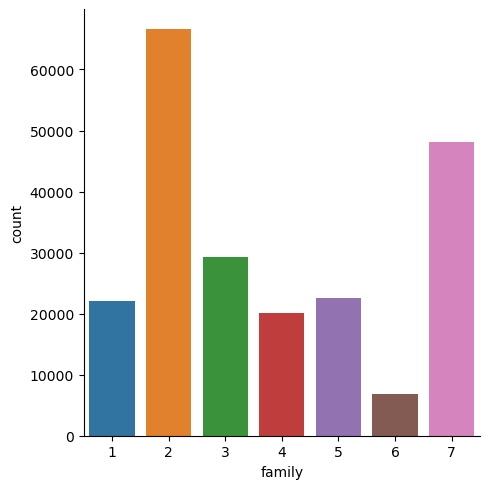

(22119, 19) (66579, 19) (29218, 19) (20048, 19) (22599, 19) (6886, 19) (48140, 19)


In [96]:
sns.catplot(x="family", kind="count", order=['1', '2', '3', '4', '5', '6', '7'], data=br) # order: 보여지는 순서
plt.show()
# 분류항목 확인
for i in range(1, 8):
    globals()[f'sc{i}'] = br[br['family'] == str(i)]
print(sc1.shape, sc2.shape, sc3.shape, sc4.shape, sc5.shape, sc6.shape, sc7.shape)

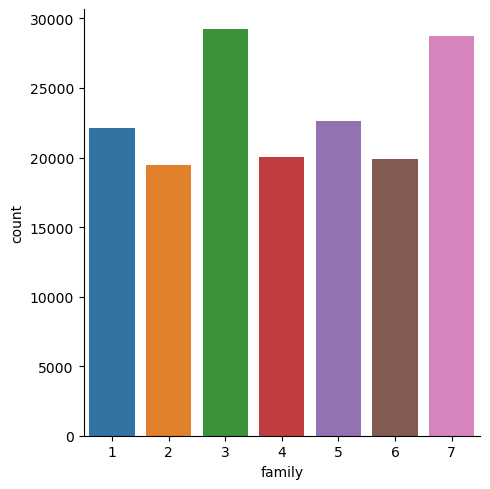

(22119, 19) (19466, 19) (29218, 19) (20048, 19) (22599, 19) (19859, 19) (28708, 19)


In [97]:
sns.catplot(x="family", kind="count", order=['1', '2', '3', '4', '5', '6', '7'], data=tpall) # order: 보여지는 순서
plt.show()
# 분류항목 확인
for i in range(1, 8):
    globals()[f'sc{i}'] = tpall[tpall['family'] == str(i)]
print(sc1.shape, sc2.shape, sc3.shape, sc4.shape, sc5.shape, sc6.shape, sc7.shape)

In [98]:
tpall.to_csv('./dataCSV/all_training_family_LCver2.csv', index=False)

In [99]:
# read csv
tpall = pd.read_csv('./dataCSV/all_training_family_LCver2.csv')
# brtest = pd.read_csv('./dataCSV/brtest_family.csv')
# brtest

C:\Users\admin\AppData\Local\Temp\ipykernel_17044\4028029096.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tpall = pd.read_csv('./dataCSV/all_training_family_LCver2.csv')


In [100]:
tpall_drop6 = tpall.drop(tpall[tpall['family'] == '6'].index)
tpall_drop = tpall_drop6.drop(tpall_drop6[tpall_drop6['family'] == '7'].index)
tpall_drop

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,3,0.296665,0.409203,0.055432,-0.039932,-0.018312,0.000000,0.000000,0.000000,0.000000,0.000000,120.384308,120.384308,0.600416,2.6588,1.0668,3.949124,0.025892,0.852795
1,3,0.651016,0.301165,0.155493,-0.012346,-0.009021,0.000000,0.000000,0.000000,0.000000,0.000000,107.514709,107.514709,0.586001,3.0180,1.1220,4.048743,0.024536,0.826089
2,3,0.500622,0.285869,0.089667,-0.009894,-0.011330,0.000000,0.000000,0.000000,0.000000,0.000000,95.947266,95.947266,0.629941,3.0112,1.0376,3.744903,0.038944,0.755377
3,4,0.700007,0.346336,0.204958,-0.018765,-0.005967,0.000000,0.000000,0.000000,0.000000,0.000000,166.415955,166.415955,0.639690,2.5904,0.9776,3.864293,0.031841,0.870975
4,4,0.592317,0.333452,0.150151,-0.019534,-0.009801,0.000000,0.000000,0.000000,0.000000,0.000000,142.836731,142.836731,0.649053,2.5528,0.9648,3.609252,0.053523,0.865887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162008,2,0.614122,0.362415,0.175596,-0.019352,-0.013154,1.967374,0.028676,0.809313,0.486517,0.792771,0.392662,156.696472,0.615181,2.5168,1.0184,3.867628,0.032319,0.836544
162009,2,0.482690,0.256190,0.075591,-0.002113,-0.017213,1.268259,0.008699,0.638355,0.388477,0.462285,0.332119,111.719727,0.774440,0.6172,0.4788,2.943307,0.073042,0.935044
162017,2,0.508241,0.311163,0.105550,-0.015424,-0.012545,1.271472,0.014364,0.744792,0.393439,0.561399,0.358794,126.884354,0.667008,1.1804,0.7500,3.095168,0.068387,0.784976
162021,2,0.464131,0.284171,0.089524,-0.012994,-0.020991,1.324425,0.010768,0.737965,0.353396,0.460837,0.318044,99.846222,0.772661,0.6460,0.4860,2.696873,0.109966,0.853097


In [45]:
brtest['family'] = brtest['family'].astype(str)
# brtest.reset_index(drop=True, inplace=True)
brtest_drop6 = brtest.drop(brtest[brtest['family'] == '6'].index)
brtest_drop = brtest_drop6.drop(brtest_drop6[brtest_drop6['family'] == '7'].index)
brtest_drop

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.318061,0.309105,0.046529,-0.017101,-0.022574,0.661041,0.006636,0.619600,0.243521,0.345884,90.631065,90.631065,0.653502,2.2780,0.9108,3.670007,0.049070,0.820424
1,3,0.008160,0.311438,-0.036762,-0.027500,-0.026577,-0.070722,0.000103,-9.659731,0.045771,0.008229,77.863335,77.863335,0.600879,2.4604,1.0428,3.876785,0.028376,0.807099
3,5,0.040049,0.323130,-0.022151,-0.029778,-0.038771,0.098288,0.000617,-0.564806,0.050785,0.041492,57.557636,57.557636,0.539844,8.3012,1.6588,4.075690,0.030049,0.583523
4,2,0.409952,0.311289,0.077786,-0.020210,-0.018079,0.956387,0.010235,0.735446,0.305214,0.434798,114.518768,114.518768,0.670106,1.7164,0.8156,3.342672,0.063547,0.776417
5,3,-0.199422,0.336944,-0.090018,-0.036498,-0.033074,-0.364843,-0.001999,1.295989,-0.062164,-0.211368,103.771088,103.771088,0.517677,13.5012,2.0604,4.512903,0.020987,0.643870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15675,4,0.646704,0.320490,0.149671,-0.016479,0.003861,1.597335,0.022840,0.782066,0.527121,0.736212,177.604675,177.604675,0.648992,2.6892,0.9756,3.660820,0.048838,0.855866
15676,1,-0.013930,0.303896,-0.035500,-0.032784,-0.032031,-0.048371,-0.000172,4.555792,0.017253,-0.012812,105.508575,105.508575,0.553296,3.7016,1.2864,4.182450,0.021536,0.776090
15677,4,0.173370,0.385757,0.037744,-0.055551,-0.049336,0.553609,0.005279,1.060665,0.089671,0.185206,105.554939,105.554939,0.567054,3.1992,1.2080,4.266226,0.019377,0.863090
15678,1,0.003297,0.421112,-0.027749,-0.067822,-0.052692,0.076764,0.000085,9.940056,-0.013308,0.003708,107.868629,107.868629,0.597042,2.4020,1.0460,3.994095,0.026922,0.878783


In [101]:
tpall_drop.to_csv('./dataCSV/all_training_family_LCver2_drop.csv', index=False)
# brtest_drop.to_csv('./dataCSV/brtest_family_drop.csv', index=False)